# Using Leafmap and Earthaccess to Explore OPERA Products

The Leafmap library provides a suite of tools for interactive mapping and visualization in Jupyter Notebooks Leafmap version 0.30.0 and and later offer tools specifically for accessing NASA Earthdata by building on the newly developed NASA Earthaccess library. Earthaccess provides streamlined access to NASA Earthdata and simplifies the authentication and querying process over previously developed approaches.This notebook is designed to leverage tools within Earthaccess and Leafmap to facility easier access and vizualization of OPERA data products for a user-specified area of interest (AOI). 


## Import Libraries

In [1]:
import earthaccess
import leafmap
import pandas as pd
import geopandas as gpd
from shapely import box
from datetime import datetime
from pyproj import Transformer
import rioxarray as rxr
import matplotlib.pyplot as plt
from localtileserver import get_leaflet_tile_layer, TileClient
import numpy as np

## Authentication 
A [NASA Earthdata Login](https://urs.earthdata.nasa.gov/) account is required to download the data used in this tutorial. You can create an account at the link provided. After establishing an account, the code in the next cell will verify authentication. If this is your first time running the notebook, you will be prompted to enter your Earthdata login credentials, which will be saved in ~/.netrc.

In [2]:
leafmap.nasa_data_login()

Enter your Earthdata Login username:  samkrasnoff
Enter your Earthdata password:  ········


## Create an interactive Leaflet map to define an area of interest (AOI) OR enter existing volcano coordinates
Leafmap provides the capability to create an interactive map in the Jupyter Notebook and to use the cursor to define an area of interest (AOI). When the user defines an AOI, the boundary is saved as an object. Give this a try in the next cell.

In [3]:
### Enter volcano coordinates here
lat = 10.2

long = -84.2

In [4]:
m = leafmap.Map(center=[lat,long], zoom=13, basemap='Google Satellite')
m

Map(center=[10.2, -84.2], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

### Below, the user can see their selected area of interest, and confirm/edit the bounds.

In [6]:
### This cell initializes the AOI for future use. If the user didn't define an AOI in the previous cell, the AOI defaults to an bounding box over Ridgecrest, California (USA)
if m.user_roi is not None:
    AOI = tuple(m.user_roi_bounds())
else:
    AOI = (long - .05, lat -.05, long + .05, lat + .05)
print(AOI)

(-84.25, 10.149999999999999, -84.15, 10.25)


## Specify a time constraint, from 2021 to present
 Please use the format YYYY-MM-DD

In [7]:
start_date = "2023-12-01"

end_date = "2024-08-30"

## Query Earthdata and return metadata for OPERA products within the AOI
The `earthaccess` library makes it simple to quickly query NASA's Common Metadata Repository (CMR) and return the associated metadata as a Geodataframe. `Leafmap` has recently added functionality that builds on `earthaccess` to enable interactive viewing of this data. 
In the next cell, the user should specify which OPERA product and the date range of interest. The AOI defined previously is used as the boundary in the query.

### View OPERA Product Shortnames

The `leafmap.nasa_data_search()` function returns a Geodataframe containing the metadata for all granules which intersect the AOI from the specified time range. Let's look at the first five granules.

### Query the OPERA DSWX-HLS dataset for the AOI

In [8]:
dswx_results, dswx_gdf = leafmap.nasa_data_search(
    short_name='OPERA_L3_DSWX-HLS_V1',
    cloud_hosted=True,
    bounding_box= AOI,
    temporal=(start_date,end_date),
    count=-1,  # use -1 to return all datasets
    return_gdf=True,
)

### See the available DSWX-HLS layers

In [9]:
dswx_results[0]

Collection: {'Version': '1.0', 'ShortName': 'OPERA_L3_DSWX-HLS_PROVISIONAL_V1'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -84.309, 'SouthBoundingCoordinate': 9.886, 'EastBoundingCoordinate': -83.298, 'NorthBoundingCoordinate': 10.888}]}}}
Temporal coverage: {'RangeDateTime': {'EndingDateTime': '2023-12-01T16:10:23.836Z', 'BeginningDateTime': '2023-12-01T16:10:23.836Z'}}
Size(MB): 39.253310203552246
Data: ['https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/OPERA_L3_DSWX-HLS_PROVISIONAL_V1/OPERA_L3_DSWx-HLS_T16PHS_20231201T160501Z_20231203T124335Z_S2A_30_v1.0_B01_WTR.tif', 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/OPERA_L3_DSWX-HLS_PROVISIONAL_V1/OPERA_L3_DSWx-HLS_T16PHS_20231201T160501Z_20231203T124335Z_S2A_30_v1.0_B02_BWTR.tif', 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/OPERA_L3_DSWX-HLS_PROVISIONAL_V1/OPERA_L3_DSWx-HLS_T16PHS_20231201T160501Z_20231203T124335Z_S2A_30_v1.0_B03_CONF.tif', 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/OPERA_L3_DSWX-HLS_PROVISIONAL_V1/OPERA_L3_DSWx-HLS_T16PHS_20231201T160501Z_20231203T124335Z_S2A_30_v1.0_B04_DIAG.tif', 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/OPERA_L3_DSWX-HLS_PROVISIONAL_V1/OPERA_L3_DSWx-HLS_T16PHS_20231201T160501Z_20231203T124335Z_S2A_30_v1.0_B05_WTR-1.tif', 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/OPERA_L3_DSWX-HLS_PROVISIONAL_V1/OPERA_L3_DSWx-HLS_T16PHS_20231201T160501Z_20231203T124335Z_S2A_30_v1.0_B06_WTR-2.tif', 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/OPERA_L3_DSWX-HLS_PROVISIONAL_V1/OPERA_L3_DSWx-HLS_T16PHS_20231201T160501Z_20231203T124335Z_S2A_30_v1.0_B07_LAND.tif', 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/OPERA_L3_DSWX-HLS_PROVISIONAL_V1/OPERA_L3_DSWx-HLS_T16PHS_20231201T160501Z_20231203T124335Z_S2A_30_v1.0_B08_SHAD.tif', 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/OPERA_L3_DSWX-HLS_PROVISIONAL_V1/OPERA_L3_DSWx-HLS_T16PHS_20231201T160501Z_20231203T124335Z_S2A_30_v1.0_B09_CLOUD.tif', 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/OPERA_L3_DSWX-HLS_PROVISIONAL_V1/OPERA_L3_DSWx-HLS_T16PHS_20231201T160501Z_20231203T124335Z_S2A_30_v1.0_B10_DEM.tif']

### View the OPERA_L3_DSWX-HLS_V1 metadata and footprints

In [10]:
dswx_gdf.head()

size concept-type           concept-id  revision-id  \
0  39.253310      granule  G2811033227-POCLOUD            1   
1  40.454058      granule  G2810866116-POCLOUD            1   
2  40.219641      granule  G2812608296-POCLOUD            1   
3  39.931794      granule  G2812637132-POCLOUD            1   
4  36.788508      granule  G2813771635-POCLOUD            1   

                                           native-id collection-concept-id  \
0  OPERA_L3_DSWx-HLS_T16PHS_20231201T160501Z_2023...   C2617126679-POCLOUD   
1  OPERA_L3_DSWx-HLS_T16PGS_20231201T160501Z_2023...   C2617126679-POCLOUD   
2  OPERA_L3_DSWx-HLS_T16PGS_20231204T160019Z_2023...   C2617126679-POCLOUD   
3  OPERA_L3_DSWx-HLS_T16PGS_20231204T160631Z_2023...   C2617126679-POCLOUD   
4  OPERA_L3_DSWx-HLS_T16PHS_20231206T154819Z_2023...   C2617126679-POCLOUD   

  provider-id                             format             revision-date  \
0     POCLOUD  application/vnd.nasa.cmr.umm+json  2023-12-03T12:47:05.273Z   
1     POCLOUD  application/vnd.nasa.cmr.umm+json  2023-12-03T09:41:31.682Z   
2     POCLOUD  application/vnd.nasa.cmr.umm+json  2023-12-06T08:08:34.809Z   
3     POCLOUD  application/vnd.nasa.cmr.umm+json  2023-12-06T09:41:32.051Z   
4     POCLOUD  application/vnd.nasa.cmr.umm+json  2023-12-08T08:08:39.649Z   

             EndingDateTime  ... CloudCover  \
0  2023-12-01T16:10:23.836Z  ...       46.0   
1  2023-12-01T16:10:26.821Z  ...       63.0   
2  2023-12-04T16:00:19.792Z  ...       38.0   
3  2023-12-04T16:20:23.265Z  ...       40.0   
4  2023-12-06T15:48:19.308Z  ...       98.0   

                                       InputGranules  \
0  [/home/conda/input_dir/GSHHS_f_L1.dbf, /home/c...   
1  [/home/conda/input_dir/GSHHS_f_L1.dbf, /home/c...   
2  [/home/conda/input_dir/GSHHS_f_L1.dbf, /home/c...   
3  [/home/conda/input_dir/GSHHS_f_L1.dbf, /home/c...   
4  [/home/conda/input_dir/GSHHS_f_L1.dbf, /home/c...   

                   ArchiveAndDistributionInformation DayNightFlag  \
0  [{'SizeUnit': 'MB', 'Size': 0.0424995422363281...  Unspecified   
1  [{'SizeUnit': 'MB', 'Size': 3.0517578125e-05, ...  Unspecified   
2  [{'SizeUnit': 'MB', 'Size': 0.5820960998535156...  Unspecified   
3  [{'SizeUnit': 'MB', 'Size': 35.2566032409668, ...  Unspecified   
4  [{'SizeUnit': 'MB', 'Size': 3.0517578125e-05, ...  Unspecified   

                                         Identifiers  \
0  [{'Identifier': 'OPERA_L3_DSWx-HLS_T16PHS_2023...   
1  [{'Identifier': 'OPERA_L3_DSWx-HLS_T16PGS_2023...   
2  [{'Identifier': 'OPERA_L3_DSWx-HLS_T16PGS_2023...   
3  [{'Identifier': 'OPERA_L3_DSWx-HLS_T16PGS_2023...   
4  [{'Identifier': 'OPERA_L3_DSWx-HLS_T16PHS_2023...   

         ProductionDateTime  \
0  2023-12-03T12:43:35.253Z   
1  2023-12-03T09:37:41.343Z   
2  2023-12-06T08:04:57.285Z   
3  2023-12-06T09:37:05.058Z   
4  2023-12-08T08:04:35.298Z   

                                                 URL   Name  \
0  https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6  UMM-G   
1  https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6  UMM-G   
2  https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6  UMM-G   
3  https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6  UMM-G   
4  https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6  UMM-G   

                                bbox  \
0  (-84.309, 9.886, -83.298, 10.888)   
1  (-85.221, 9.895, -84.211, 10.895)   
2  (-85.221, 9.895, -84.211, 10.895)   
3  (-85.221, 9.895, -84.211, 10.895)   
4  (-84.309, 9.886, -83.298, 10.888)   

                                            geometry  
0  POLYGON ((-83.29800 9.88600, -83.29800 10.8880...  
1  POLYGON ((-84.21100 9.89500, -84.21100 10.8950...  
2  POLYGON ((-84.21100 9.89500, -84.21100 10.8950...  
3  POLYGON ((-84.21100 9.89500, -84.21100 10.8950...  
4  POLYGON ((-83.29800 9.88600, -83.29800 10.8880...  

[5 rows x 29 columns]

In [11]:
### Plot the location of the tiles 
dswx_gdf.explore(fill=False)

## Download data with leafmap
*<font color='red'>Important note: As of Jan. 2024, OPERA RTC and CSLC may not be accessible using the earthaccess library due to additional athentication measures required by ASF DAAC. This will likely be resolved soon, but currently the notebook should be used only to access OPERA products dswxributed by LP DAAC and PO.DAAC. For additional details regarding the current status of using earthaccess to access data from ASF DAAC, see the linked Github Issue ([#439](https://github.com/nsidc/earthaccess/issues/439#issuecomment-1915518987)).</font>*

Let's download some data from one of our above queries. In the cell below we specify data from the dswx query, but feel free to modify to any of the others above. *Note: We also filter to include the layer we would like to from the product we would like. So modify this step accordingly if a different product is chosen.

### Create a subdirectory
This will be where the files are downloaded. It will be a subdirectory inside of a directory called `data`, and the directory name will be the datetime that it was created.

In [12]:
import os
from datetime import datetime

def create_data_directory():
    # Get the current date and time
    current_datetime = datetime.now().strftime("%m_%d_%Y_%H_%M_%S")
    volcano = "Poas"
    # Define the base directory
    base_directory = "data"

    # Create the full path for the new directory
    new_directory_path = os.path.join(base_directory, f"data_{volcano}")

    # Create the new directory
    os.makedirs(new_directory_path, exist_ok=True)
    print(f"Directory '{new_directory_path}' created successfully.")

    return new_directory_path, volcano

directory_path, volcano = create_data_directory()

Directory 'data/data_Poas' created successfully.


### Download the data
The below will download the data to your newly created subdirectory. Look on your file system for a directory `/data/datetime/` where `datetime` is the date and time the directory was created.

In [13]:
dswx_data = leafmap.nasa_data_download(dswx_results, out_dir=directory_path)     # Downloads the first 5 granules. Remove [:5] to download all granules or modify to keep as many as you like

QUEUEING TASKS | :   0%|          | 0/2010 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2010 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2010 [00:00<?, ?it/s]

## View the files using Leafmap

### Load in images from data folder
We load in data from only band 1 below. If you'd like load data from a different band change the `B01` to suit your needs.

In [49]:
import os

# Get the current directory
current_directory = os.getcwd()

# Construct the path to the data directory
data_directory = os.path.join(current_directory, directory_path)

# Create a list of file paths and a list of corresponding dates
images = [os.path.join(data_directory, filename) for filename in os.listdir(data_directory) if os.path.isfile(os.path.join(data_directory, filename)) and '_WTR' in filename]


val = images[0].find("-")
tiling = [w[val+5:val+11] for w in images]
tiles = []
for x in tiling:
    if x not in tiles:
        tiles.append(x)
granules = dict()
for tile in tiles:
    granules[tile] = []

for count, image in enumerate(images):
    if 'WTR' in image and 'WTR-1' not in image and 'WTR-2' not in image:
        granules[tiling[count]].append(image)
time = 1
for key in granules:
    granules[key].sort(key=lambda x: x[val+13:val+21])

### Select the best granule for your data

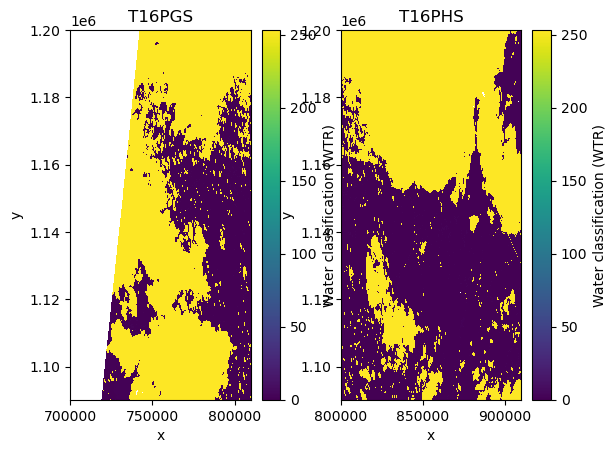

In [56]:
fig, axs = plt.subplots(ncols=len(granules.keys()))
for i, key in enumerate(granules):
    dem = rxr.open_rasterio(granules[key][0], masked=True)
    dem.plot(ax=axs[i])
    axs[i].set_title(key)
plt.show()

In [57]:
granule = "T16PHS"

## Select area of interest within granule

In [58]:
m = leafmap.Map()
m.add_raster(granules[granule][0])
m

Map(center=[10.3424975, -83.75930199999999], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_…

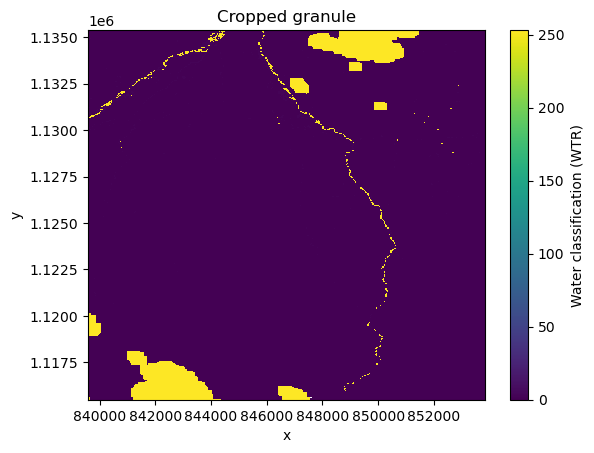

In [71]:
dem = rxr.open_rasterio(granules[granule][0],masked=True)
project = dem.rio.crs.to_epsg()
transformer = Transformer.from_crs("EPSG:4326",f"EPSG:{project}")
x = m.user_roi_bounds()
ll = transformer.transform(x[1],x[0])
ur = transformer.transform(x[3],x[2])
dem = dem.sel(x=slice(ll[0],ur[0]))
dem = dem.sel(y=slice(ur[1],ll[1]))
dem.plot()
plt.title("Cropped granule")
plt.show()

In [73]:
from osgeo import gdal
import subprocess
dataset = []
for tif in granules[granule]:
    filename = granules[granule][0].split("/")[-1]
    filepath = '/'.join(granules[granule][0].split("/")[:-1])
    window = (ll[0],ur[1],ur[0],ll[1])
    window = (x[0],x[3],x[2],x[1])
    new_name = ''.join((filepath, "/cropped_",filename))
    dataset.append(new_name)
    subprocess.run(f"gdal_translate -projwin {ll[0]}, {ur[1]}, {ur[0]}, {ll[1]} -f GTiff {granules[granule][0]} {new_name}",shell=True)


/home/jovyan/NASA/data/data_Poas/cropped_OPERA_L3_DSWx-HLS_T16PHS_20231201T160501Z_20231203T124335Z_S2A_30_v1.0_B01_WTR.tif
/home/jovyan/NASA/data/data_Poas/cropped_OPERA_L3_DSWx-HLS_T16PHS_20231201T160501Z_20231203T124335Z_S2A_30_v1.0_B01_WTR.tif
/home/jovyan/NASA/data/data_Poas/cropped_OPERA_L3_DSWx-HLS_T16PHS_20231201T160501Z_20231203T124335Z_S2A_30_v1.0_B01_WTR.tif
/home/jovyan/NASA/data/data_Poas/cropped_OPERA_L3_DSWx-HLS_T16PHS_20231201T160501Z_20231203T124335Z_S2A_30_v1.0_B01_WTR.tif
/home/jovyan/NASA/data/data_Poas/cropped_OPERA_L3_DSWx-HLS_T16PHS_20231201T160501Z_20231203T124335Z_S2A_30_v1.0_B01_WTR.tif
/home/jovyan/NASA/data/data_Poas/cropped_OPERA_L3_DSWx-HLS_T16PHS_20231201T160501Z_20231203T124335Z_S2A_30_v1.0_B01_WTR.tif
/home/jovyan/NASA/data/data_Poas/cropped_OPERA_L3_DSWx-HLS_T16PHS_20231201T160501Z_20231203T124335Z_S2A_30_v1.0_B01_WTR.tif
/home/jovyan/NASA/data/data_Poas/cropped_OPERA_L3_DSWx-HLS_T16PHS_20231201T160501Z_20231203T124335Z_S2A_30_v1.0_B01_WTR.tif
/home/jo

### Create a timelapse (.gif) of the images over this region

In [ ]:
leafmap.create_timelapse(
    dataset,
    out_gif='dswx-anom.gif',
    fps=1,
    progress_bar_color='blue',
    add_text=False,
    # text_xy=('3%', '3%'),
    # text_sequence=[str(date) for date in granules[granule][88+len(volcano):88+len(volcano)+8]],
    font_size=20,
    font_color='red',
    mp4=False,
    reduce_size=False,
)

In [ ]:
leafmap.show_image('dswx-anom.gif',height="450px", width="450px")

## View OPERA data in Leafmap GUI

In [ ]:
m = leafmap.Map()
m.add("nasa_earth_data")
m

### Download the Displayed Footprints

## Make a timeslider to visualize granules
Make an interactive timeslide to cycle through the images. This isn't the perfect solution, as the granules in our list do not have identical footprints.

In [ ]:
m = leafmap.Map()
m.add_time_slider(
    dataset,
    time_interval=1,
    position='bottomright',
    zoom_to_layer=True,
)
m

In [ ]:
mean = []
percentile_75 = []
for timestamp in granules[granule]:
    snapshot = rxr.open_rasterio(timestamp,masked=True)
    mean.append(snapshot.mean())
    flattened = snapshot.values.flatten()
    flattened = flattened[~np.isnan(flattened)]
    percentile_75.append(np.percentile(flattened,95))
plt.plot(mean)
plt.plot(percentile_75)

# for i in range(4):
#     ax1 = plt.subplot(2, 2, i+1)
#     altered_dem = dem.where(dem > vals[i])
#     altered_dem.plot()
#     plt.title('')
plt.show()